<a href="https://colab.research.google.com/github/Auusi/Machine_Learning_Spotify/blob/main/MLSPOTIFY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploración y análisis de datos

## -- Conectar Drive

In [82]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## -- Carga y procesado de datos

In [83]:
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

ruta_de_archivos = '/content/drive/MyDrive/UPSO/BigData/Datasets/Canciones_Spotify/Canciones_Spotify.csv'
dataframe = pd.read_csv(ruta_de_archivos)
df = dataframe.copy ()

#Limpieza de datos no numericos y de NaN
df ['target'] = pd.to_numeric(df ['target'], errors='coerce')
df = df.loc[~df['target'].isna()]

#Borrado de columnas irrelevantes
df = df.drop(columns=['Unnamed: 0', 'duration_ms', 'time_signature','song_title','mode','key'])

# Crear una instancia del codificador
# Transformar la columna 'artist' en tu DataFrame para que sean valores numericos
df['artist'] = LabelEncoder().fit_transform(df['artist'])

### Decidimos crear una matriz de correlación y observar sus datos en barras para apreciar mas fácilmente los valores

In [84]:
X = df.drop(columns=['target'])   # Características
y = df['target']                  # Etiqueta

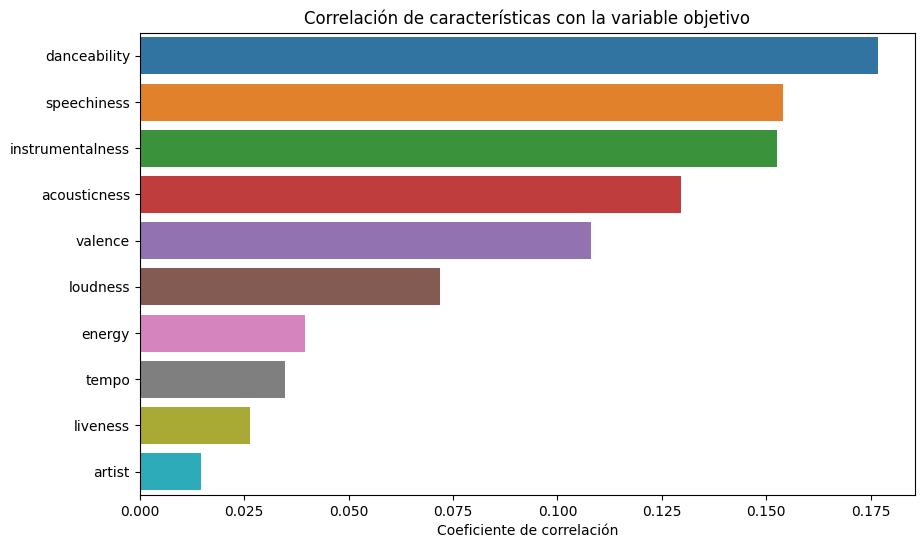

In [85]:
correlation_matrix = X.corrwith(y)
correlation_matrix = correlation_matrix.abs().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=correlation_matrix.values, y=correlation_matrix.index, orient='h')
plt.title('Correlación de características con la variable objetivo')
plt.xlabel('Coeficiente de correlación')
plt.show()

### Borramos las caracteristicas livenness y artist que son las que mas baja correlacion tienen el target para poder tener modelos mas precisos.

In [86]:
X = df.drop(columns=['artist','liveness'])

## -- Definimos un conjunto de entrenamiento (80 %) y un conjunto para testeo (20 %)

In [87]:
 X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# KNN

## -- Selección de parámetros

### Buscamos los mejores parámetros para ejecutar el modelo

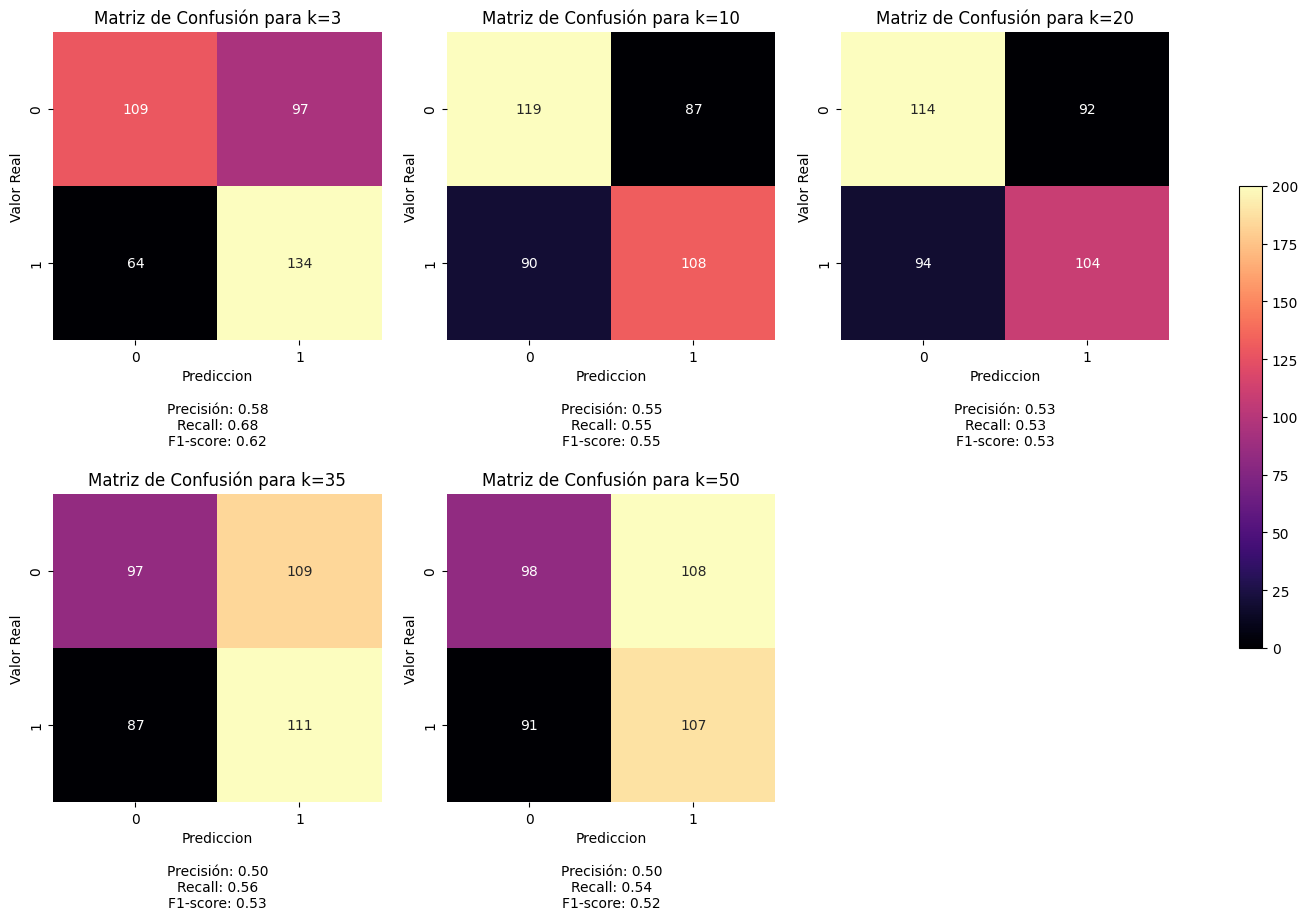

In [88]:
# Lista para almacenar los valores de k y las métricas
k_values = [3, 10, 20, 35, 50]  # Ajustamos valores según necesidades

# Inicializa un contador para organizar la visualización
plot_count = 0

# Ajusta el tamaño de la figura (mayor tamaño)
plt.figure(figsize=(18, 10))
plt.subplots_adjust(hspace=0.5)


for k in k_values:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train, y_train)
    y_pred = knn_model.predict(X_test)

    confusion = confusion_matrix(y_test, y_pred)

    # Incrementa el contador
    plot_count += 1

    # Calcular precisión, recall y F1-score
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)


    # Grafica la matriz de confusión
    plt.subplot(2, 3, plot_count)
    sns.heatmap(confusion, annot=True, fmt="d", cmap="magma", cbar=False)
    plt.title(f'Matriz de Confusión para k={k}')
    plt.xlabel(f'Predicción')
    plt.xlabel(f'Prediccion\n\nPrecisión: {precision:.2f}\nRecall: {recall:.2f}\nF1-score: {f1:.2f}')
    plt.ylabel('Valor Real')


cmap = plt.get_cmap("magma")
norm = plt.Normalize(0, 200)  # Utiliza el valor máximo de la matriz
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Agrega la barra de colores (leyenda)
cbar = plt.colorbar(sm, ax=plt.gcf().get_axes(), orientation='vertical', shrink=0.6, aspect=20)
plt.show()

## -- Entrenamiento y evaluación del modelo

#### Al principio probamos con los mismos valores, pero en vez de K = 3 habiamos elegido el 1, por esto nos dimos cuenta que con un valor en K mas chico el modelo da mejores metricas, pero decidimos elegir el 3 para conseguir un modelo  más robusto y generalizable

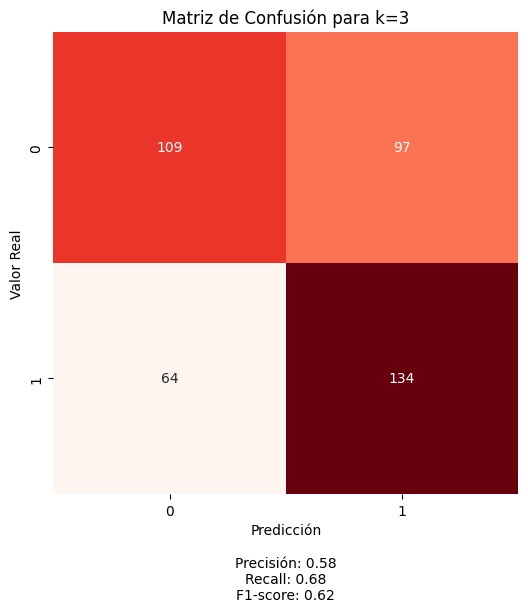

In [89]:
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(X_train, y_train)
knn_pred = knn_model.predict(X_test) # Guardamos predicción de KNeighborsClassifier

confusion = confusion_matrix(y_test, knn_pred)

# Calcular precisión, recall y F1-score
precision = precision_score(y_test, knn_pred)
recall = recall_score(y_test, knn_pred)
f1 = f1_score(y_test, knn_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(6, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Reds", cbar=False)
plt.title(f'Matriz de Confusión para k={3}')
plt.xlabel(f'Predicción\n\nPrecisión: {precision:.2f}\nRecall: {recall:.2f}\nF1-score: {f1:.2f}')
plt.ylabel('Valor Real')
plt.show()



## -- Validación cruzada

### Validación KNN - cross validation

In [90]:
knn = KNeighborsClassifier(n_neighbors=3)

scores = cross_val_score(knn, X, y.ravel(), cv=5) # Se realiza 5 veces

print("Scores de validación knn (validación cruzada):", scores) # Valores de cada validación
print("Media de los scores:", scores.mean())
print("Desviación estándar de los scores:", scores.std())


Scores de validación knn (validación cruzada): [0.56435644 0.50247525 0.56327543 0.56823821 0.55583127]
Media de los scores: 0.5508353192639363
Desviación estándar de los scores: 0.02451160456045807


### Validación K-Fold - cross validation

In [91]:
cv = KFold(n_splits=5, shuffle=True, random_state=7) # Se realiza 5 veces

scores = cross_val_score(knn, X, y.ravel(), cv=cv)

print("Scores de validación KFold (validación cruzada):", scores) # Valores de cada validación
print("Media de los scores:", scores.mean())
print("Desviación estándar de los scores:", scores.std())

Scores de validación KFold (validación cruzada): [0.60643564 0.60643564 0.58064516 0.60297767 0.58808933]
Media de los scores: 0.5969166891875292
Desviación estándar de los scores: 0.010589063535388061


# SVM

## -- Selección de parámetros

### Utilizamos Grid_Search para encontrar los mejores hiperparámetros (C y gamma) para el modelo SVM

In [92]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Define los valores posibles para kernel, C y gamma
param_grid = {
    'kernel': ['rbf'],
    'C': [0.1, 1, 10],
    'gamma': [0.1, 1,5, 10]
}

# Crea un modelo SVM
svm_model = SVC()

# Aplica Grid Search con validación cruzada
grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Obtiene los mejores parámetros encontrados
best_params = grid_search.best_params_

print("Mejores parámetros:", best_params)
print("Mejor score:", grid_search.best_score_)

Mejores parámetros: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Mejor score: 0.6007153433455762


### Utilizamos Randomized_Search para encontrar los mejores hiperparámetros (C y gamma) para el modelo SVM

In [93]:
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

# Define las distribuciones de probabilidad para kernel, C y gamma
param_dist = {
    'kernel': ['rbf'],
    'C': reciprocal(0.1, 100),
    'gamma': reciprocal(0.01, 10)
}

# Crea un modelo SVM
svm_model = SVC()

# Aplica Random Search con validación cruzada
random_search = RandomizedSearchCV(svm_model, param_distributions=param_dist, n_iter=10, cv=5, scoring='accuracy')
random_search.fit(X_train, y_train)

# Obtiene los mejores parámetros encontrados
best_params = random_search.best_params_

print("Mejores parámetros:", best_params)
print("Mejor score:", grid_search.best_score_)

Mejores parámetros: {'C': 16.926065212122367, 'gamma': 0.01587128945409112, 'kernel': 'rbf'}
Mejor score: 0.6007153433455762


### Decidimos quedarnos con los parametros mas chicos tanto en C como en Gamma para lograr un aprendizaje mas general y no sobreajustar los datos

## -- Entrenamiento y evaluación del modelo

#### (La mayoria de las veces que ejecutamos RandomizedSearch nos daba valores mas grandes en ambos hiperparametros. Decidimos solo utilizar el Kernel RBF porque el linear da todo los puntajes en 1.0)

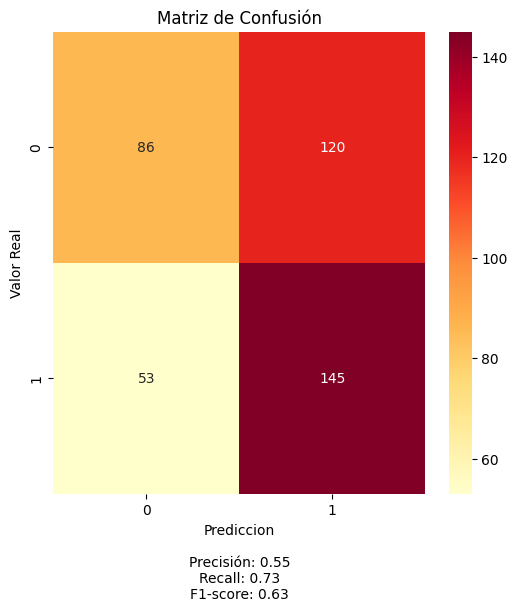

In [94]:
svc_best = SVC(C= 10 , gamma=0.1, kernel='rbf')
svc_best.fit(X_train, y_train)

svm_pred  = svc_best.predict(X_test) #guardamos prediccion de Super Vector Machine

precision = precision_score(y_test, svm_pred)
recall = recall_score(y_test, svm_pred )
f1 = f1_score(y_test, svm_pred )

c = confusion_matrix(y_test, svm_pred )

# Crea una figura y un eje
plt.figure(figsize=(6, 6))
ax = plt.subplot()

# Crea una matriz de calor (heatmap) con seaborn
sns.heatmap(c, annot=True, fmt='d', cmap='YlOrRd')

# Configura etiquetas y títulos
ax.set_ylabel('Valor Real')
ax.set_xlabel(f'Prediccion\n\nPrecisión: {precision:.2f}\nRecall: {recall:.2f}\nF1-score: {f1:.2f}')
ax.set_title('Matriz de Confusión')

# Muestra la matriz de confusión
plt.show()

# Naive Bayes

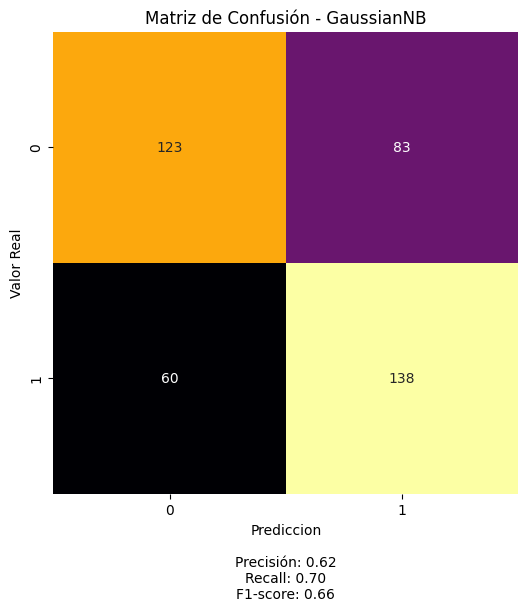

In [95]:
from sklearn.metrics import confusion_matrix

naive_bayes = GaussianNB()
naive_bayes.fit(X_train, y_train)

naive_bayes_pred = naive_bayes.predict(X_test) #guardamos prediccion de Naive Bayes

# Matriz de confusión del modelo Naive Bayes
cm_naive_bayes = confusion_matrix(y_test, naive_bayes_pred)

precision = precision_score(y_test, naive_bayes_pred)
recall = recall_score(y_test, naive_bayes_pred)
f1 = f1_score(y_test, naive_bayes_pred)

# Graficar matriz de confusión de GaussianNB
plt.figure(figsize=(6, 6))
sns.heatmap(cm_naive_bayes, annot=True, fmt="d", cmap="inferno", cbar=False)
plt.title('Matriz de Confusión - GaussianNB')
plt.xlabel(f'Prediccion\n\nPrecisión: {precision:.2f}\nRecall: {recall:.2f}\nF1-score: {f1:.2f}')
plt.ylabel('Valor Real')
plt.show()

precision = precision_score(y_test, naive_bayes_pred)
recall = recall_score(y_test, naive_bayes_pred)
f1 = f1_score(y_test, naive_bayes_pred)

# Decision Tree

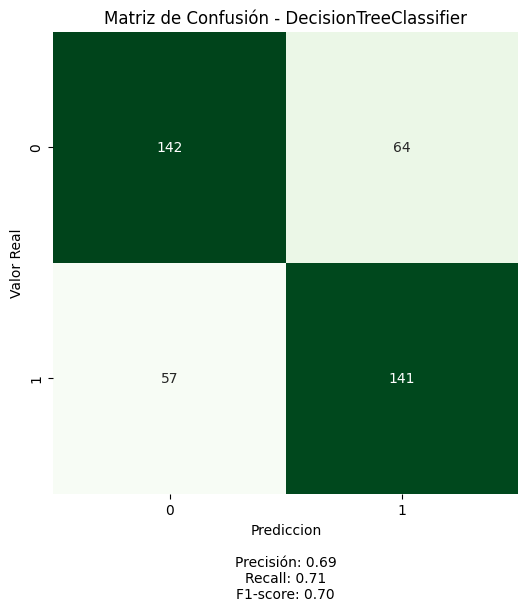

In [96]:
decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(X_train, y_train)

decision_tree_pred = decision_tree.predict(X_test) # Guardamos predicción de Decision Tree

# Matriz de confusión del modelo Árbol de Decisión
cm_decision_tree = confusion_matrix(y_test, decision_tree_pred)

precision = precision_score(y_test, decision_tree_pred)
recall = recall_score(y_test, decision_tree_pred)
f1 = f1_score(y_test, decision_tree_pred)

# Graficar matriz de confusión de DecisionTreeClassifier
plt.figure(figsize=(6, 6))
sns.heatmap(cm_decision_tree, annot=True, fmt="d", cmap="Greens", cbar=False)
plt.title('Matriz de Confusión - DecisionTreeClassifier')
plt.xlabel(f'Prediccion\n\nPrecisión: {precision:.2f}\nRecall: {recall:.2f}\nF1-score: {f1:.2f}')
plt.ylabel('Valor Real')
plt.show()

# Logistic Regression

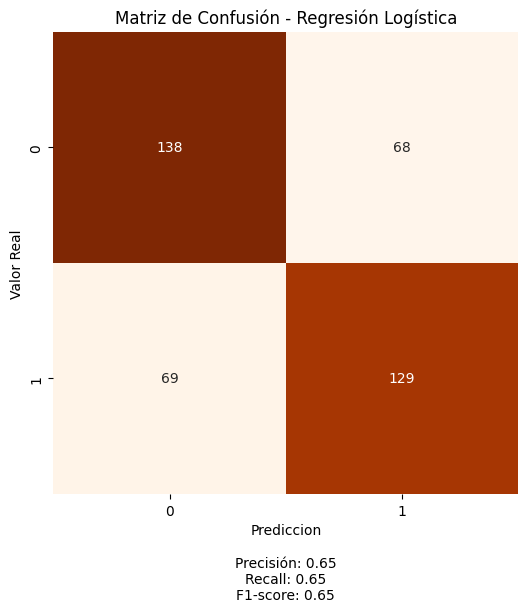

In [97]:
from sklearn.linear_model import LogisticRegression

# Crea y entrena un modelo de Regresión Logística
logistic_regression = LogisticRegression(random_state=42,max_iter=1000) #Nos daba un error asique tuvimos que setearle mas iteraciones
logistic_regression.fit(X_train, y_train)

# Realiza predicciones
logistic_regression_pred = logistic_regression.predict(X_test) #guardamos prediccion de Logistic Regression

precision = precision_score(y_test, logistic_regression_pred )
recall = recall_score(y_test, logistic_regression_pred )
f1 = f1_score(y_test, logistic_regression_pred )

# Calcula la matriz de confusión
logistic_regression_confusion = confusion_matrix(y_test, logistic_regression_pred)

# Grafica la matriz de confusión
plt.figure(figsize=(6, 6))
sns.heatmap(logistic_regression_confusion, annot=True, fmt="d", cmap="Oranges", cbar=False)
plt.title('Matriz de Confusión - Regresión Logística')
plt.xlabel(f'Prediccion\n\nPrecisión: {precision:.2f}\nRecall: {recall:.2f}\nF1-score: {f1:.2f}')
plt.ylabel('Valor Real')
plt.show()

# Ensamble - Votación Mayoritaria

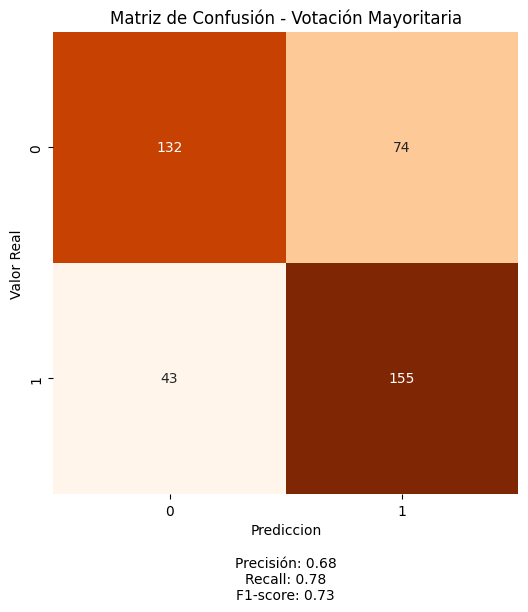

In [98]:
final_predictions = []
for k, s , nb, dt, lr in zip(knn_pred, svm_pred, naive_bayes_pred, decision_tree_pred, logistic_regression_pred):

    votes = {0: 0, 1: 0}
    votes[k] += 1
    votes[s] += 1
    votes[nb] += 1
    votes[dt] += 1
    votes[lr] += 1

    majority_vote = max(votes, key=votes.get)
    final_predictions.append(majority_vote)

final_confusion_matrix = confusion_matrix(y_test, final_predictions)

precision = precision_score(y_test, final_predictions )
recall = recall_score(y_test, final_predictions )
f1 = f1_score(y_test, final_predictions )

# Grafica la matriz de confusión
plt.figure(figsize=(6, 6))
sns.heatmap(final_confusion_matrix, annot=True, fmt="d", cmap="Oranges", cbar=False)
plt.title('Matriz de Confusión - Votación Mayoritaria')
plt.xlabel(f'Prediccion\n\nPrecisión: {precision:.2f}\nRecall: {recall:.2f}\nF1-score: {f1:.2f}')
plt.ylabel('Valor Real')
plt.show()

# Conclusión

### En conclusión, nuestros experimentos revelaron la trascendental importancia de la selección de características en el desarrollo de modelos de Machine Learning. En un principio, al mantener las columnas "liveness" y "artist" en nuestro conjunto de datos, ninguno de los cinco modelos probados de manera individual lograba superar un puntaje de 0.7 en ninguna de las métricas de evaluación. Esto evidenciaba una alta presencia de ruido en los datos y dificultaba la capacidad predictiva de los modelos, aun así el ensamble con estas dos características alcanzo un + 0.8 de score en las métricas.

### Sin embargo, cuando eliminamos estas columnas, presenciamos un notable cambio en el rendimiento de nuestros modelos. Dos de los modelos más utilizados en clase, K-Nearest Neighbors (KNN) y Support Vector Machine (SVM), lograron métricas por encima del 0.8 y 0.9, respectivamente. Y los modelos de Naive Bayes, Decision Tree y Logistic Regression alcanzaron un 100% de precisión, lo que refleja en un ensamble con predicciones perfectas.

### Se pueden apreciar estos cambios si se comenta o se omite la celda con el siguiente contenido:
### X = df.drop(columns=['artist','liveness'])